In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import tqdm
import os
import time
import random
import pickle
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.autograd import Variable
import torch.nn.functional as F
from dataset import SplinterDataset, SEQ_LEN, LSPAN, RSPAN
from network import PositionalUNet, RNN
from tools import (calc_current_amplitude, process_all_waveforms, get_tail_slope,check_peak_alignment,
                   inf_train_gen, LambdaLR, weights_init_normal, select_quantile, calculate_iou, calculate_tn)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", DEVICE)
torch.cuda.empty_cache()

BATCH_SIZE = 32
sample_rate= 16 # out frequency, for Flashcam it is 16 ns
eng_peak = 'sep'
eng_peak_load = 'fep'
home_dir='/nas/longleaf/home/kbhimani/'
save_dir = "/work/users/k/b/kbhimani/CPU-Net"
det_pulses=home_dir+f'CPU-Net/training_data/{eng_peak}_wf_ornl.pickle'
sim_pulses = home_dir + f"/CPU-Net/training_data/{eng_peak}_wf_sim.pickle"
# sim_pulses=home_dir+f'CPU-Net/training_data/{eng_peak}_valid_transfromed.pkl'

Running on cuda:0


In [2]:
# An example of how to load the waveforms from pickle file
import pickle

with open(det_pulses, "rb") as openfile:
    while True:
        try:
            wdict = pickle.load(openfile, encoding='latin1')
            print(wdict.keys())  # Add this line to debug
            test_wf = wdict["wf"]
        except EOFError:
            break  # Exit the loop when end of file is reached
        except KeyError:
            print("Key 'wf' not found in dictionary.")
            continue  # Continue to the next iteration if 'wf' key is missing
        # You can add more except blocks as needed for handling other exceptions
        break

dict_keys(['energy', 'tp0', 'wf'])


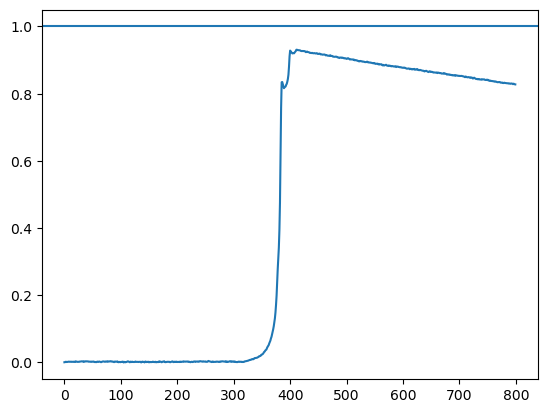

In [3]:
# An example of how to pad and normalize the waveforms
def transform(wf, tp0):
    """Transform waveform by padding based on tp0 and then normalizing."""
    wf = np.array(wf)
    # Ensure tp0 is an integer
    tp0 = int(round(tp0))
    left_padding = max(LSPAN - tp0, 0)
    right_padding = max((RSPAN + tp0) - len(wf), 0)
    # Apply padding
    wf_padded = np.pad(wf, (left_padding, right_padding), mode='edge')
    # Adjust tp0 after padding
    tp0_adjusted = tp0 + left_padding
    # Slice the waveform around the adjusted tp0 to ensure consistent length
    wf_sliced = wf_padded[(tp0_adjusted - LSPAN):(tp0_adjusted + RSPAN)]
    # Normalize the waveform after padding and slicing
    wf_normalized = normalize_waveform(wf_sliced)
    return wf_normalized

def normalize_waveform(wf):
    """Normalize waveform by dividing by the average of the last 5 samples and ensuring all values are greater than zero, 
       then scale the waveform so the maximum value is one."""
    norm_tail_height = 0.80
    norm_samples = 5
    tail_mean = np.mean(wf[-norm_samples:])  # Define the tail region as the last `norm_samples` samples
    if tail_mean <= 1:
        return wf
    if tail_mean != 0:
        normalized_wf = wf * norm_tail_height / tail_mean
    else:
        normalized_wf = wf  # If the tail mean is zero, return the waveform as is to avoid division by zero
    
    # Ensure all values are greater than zero
    min_val = np.min(normalized_wf)
    if min_val < 0:
        normalized_wf = normalized_wf - min_val  # Shift the waveform up to make all values positive
    
    # Scale the waveform so the maximum value is one
    # max_val = np.max(normalized_wf)
    # if max_val != 0:
    #     normalized_wf = normalized_wf / max_val

    return normalized_wf


tp0 = calculate_tn(test_wf,99)
transformed_wf=transform(test_wf,tp0)
plt.axhline(1)
plt.plot(transformed_wf)

In [4]:
def differentiable_get_tail_slope(wf, sample=300):
    """
    Differentiable approximation of the get_tail_slope function that returns the slope (popt[0]) of the log-linear fit on the tail of the waveform.

    Parameters:
    - wf (torch.Tensor): The input waveform, expected to be a 1D tensor.
    - sample (int): The number of samples from the end of the waveform to use for slope estimation.

    Returns:
    - slope (torch.Tensor): The estimated slope of the log-linear fit (equivalent to popt[0] in the original function).
    """
    # Ensure that the waveform is a tensor
    if not isinstance(wf, torch.Tensor):
        wf = torch.tensor(wf, dtype=torch.float32)

    # If the waveform is shorter than the sample size, return 0
    if wf.size(0) < sample:
        return torch.tensor(0.0)

    # Extract the tail part of the waveform
    tail = wf[-sample:]
    
    # Avoid log(0) by clamping the values
    tail_clamped = torch.clamp(tail, min=1e-10)
    
    # Calculate the natural logarithm of the tail
    log_tail = torch.log(tail_clamped)
    
    # Create a tensor of x_data (time steps)
    x_data = torch.arange(0, sample, dtype=torch.float32, device=wf.device)
    
    # Perform linear regression to estimate the slope
    A = torch.stack([x_data, torch.ones_like(x_data)], dim=1)  # Design matrix
    solution = torch.linalg.lstsq(A, log_tail.view(-1, 1)).solution
    
    # The slope corresponds to the first element of the solution
    slope = solution[0, 0]
    
    return slope
print(differentiable_get_tail_slope(transformed_wf).item())

-0.0002921113627962768


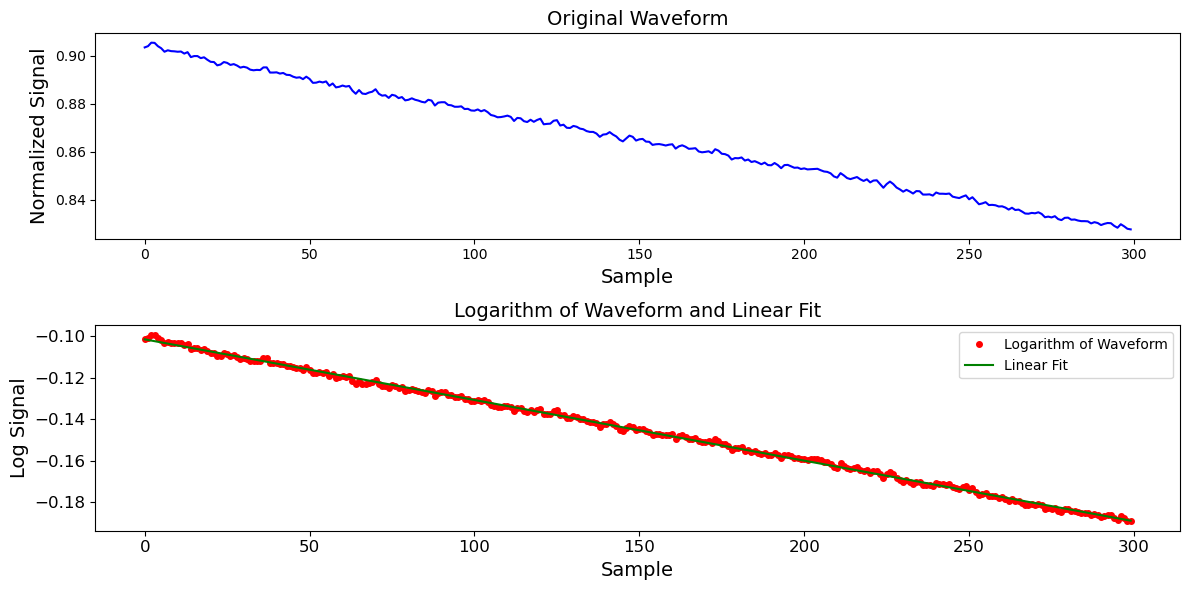

Uncertinty = [[       nan 0.        ]
 [0.         0.00080077]]


/tmp/ipykernel_3667858/231218388.py:3: RuntimeWarning: invalid value encountered in sqrt
  print('Uncertinty =', np.sqrt(np.diag(a)))


In [5]:
# This show how the tail slope is calculated by doing a linear fit of log of last 300 sample od the waveform
a =get_tail_slope(transformed_wf,plot_sample=True, return_uncertainty=True)
print('Uncertinty =', np.sqrt(np.diag(a)))

In [6]:
a[1]/16

4.0077038025449986e-08

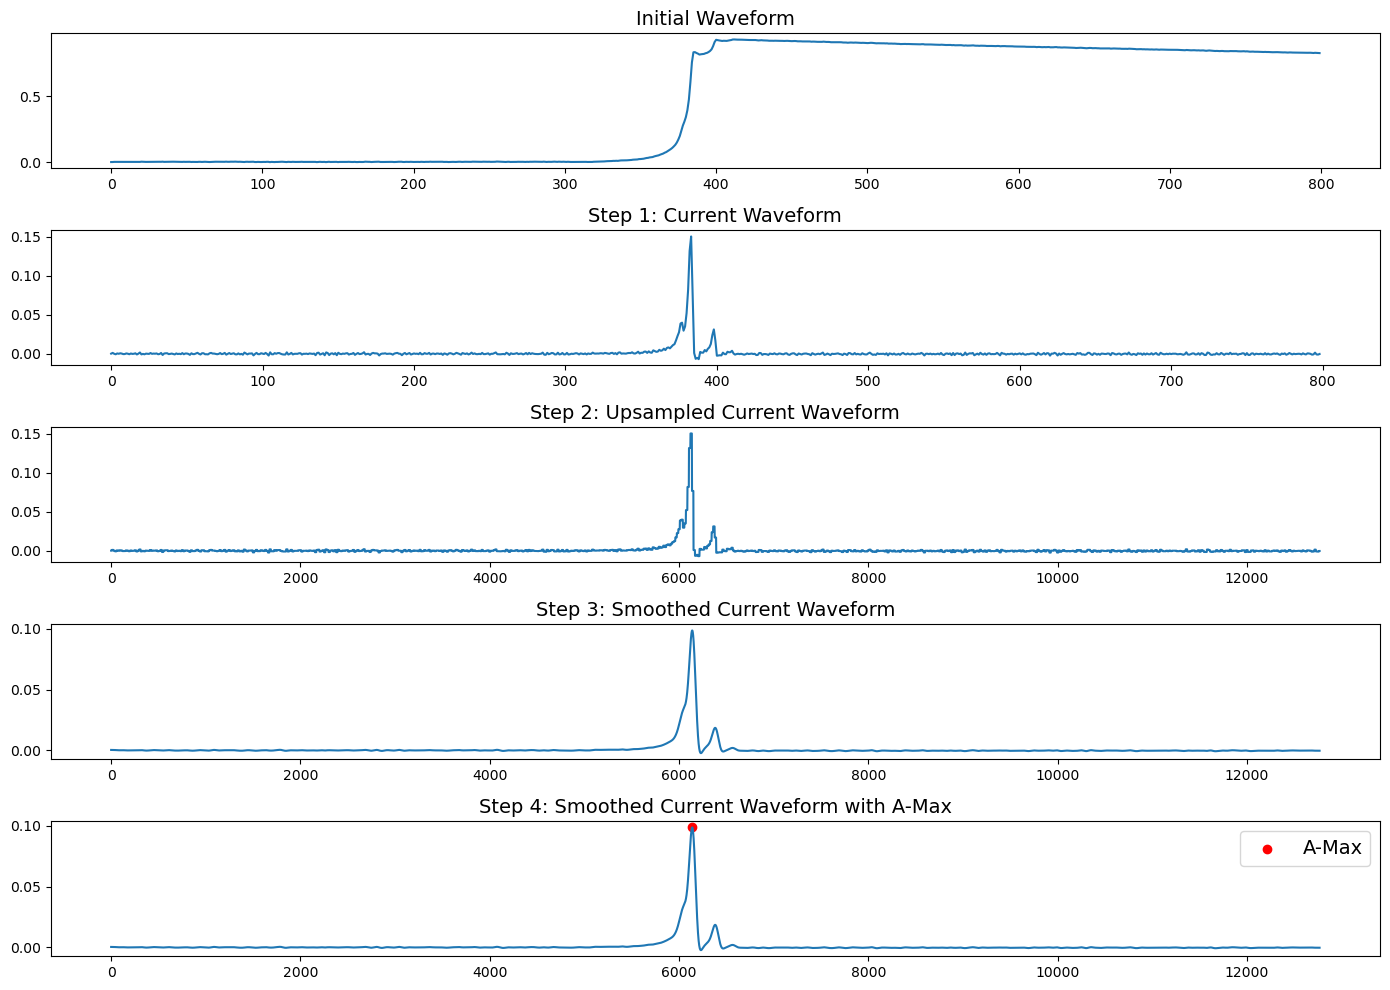

0.09851006440024956

In [7]:
# This shows the steps for calculating the current amplitude
calc_current_amplitude(transformed_wf,plot=True)

In [8]:
chi_squared_cut = 0.1022
tau_cut_low = -3.1e-4
tau_cut_high = -2.77e-4

dataset = SplinterDataset(det_pulses, sim_pulses, n_max=1e6, chi_squared_threshold=chi_squared_cut, popt_threshold_under=tau_cut_low, popt_threshold_over=tau_cut_high)
validation_split = 0
shuffle_dataset = True
random_seed= 42222
indices = np.arange(len(dataset))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
split = int(validation_split*len(dataset))
train_indices, val_indices = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
dataset.set_raw_waveform(False)
train_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler,  drop_last=True)
test_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=valid_sampler,  drop_last=True)
data = inf_train_gen(train_loader)

Chi squared cut is 0.1022
Tail slope cut over is -0.000277
Tail slope cut under is -0.00031
10000 waveforms loaded from data.
Number of Data events: 15116
10000 waveforms loaded from simulations.
Number of Simulations events 12701


In [9]:
REN = PositionalUNet()
REN.to(DEVICE)

iter_load = 9500
#model_weights_stable
# pretrained_dict = torch.load(f'{save_dir}/model_weights_stable/{eng_peak_load}_REN.pt')
pretrained_dict = torch.load(f'{home_dir}CPU-Net/model_weights/{eng_peak_load}_REN.pt')
# pretrained_dict = torch.load(f'model_weights/iter_weights/{iter_load}_{eng_peak_load}_REN.pt',weights_only=True)

# pretrained_dict = torch.load('fep_training/REN_epoch_1.pt')
model_dict = REN.state_dict()
model_dict.update(pretrained_dict) 
REN.load_state_dict(pretrained_dict)
REN.eval()

IREN = PositionalUNet()
IREN.to(DEVICE)
pretrained_dict_inv = torch.load(f'{home_dir}CPU-Net/model_weights/{eng_peak_load}_IREN.pt')
# pretrained_dict_inv = torch.load(f'model_weights/iter_weights/{iter_load}_{eng_peak_load}_IREN.pt',weights_only=True)
# pretrained_dict = torch.load('fep_training/REN_epoch_1.pt')

model_dict_inv = IREN.state_dict()
model_dict_inv.update(pretrained_dict_inv) 
IREN.load_state_dict(pretrained_dict_inv)
IREN.eval()

/tmp/ipykernel_3667858/662374775.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(f'{home_dir}CPU-Net/model_weights/{eng_peak_load}_REN.pt')


PositionalUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv1d(1, 40, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
      (1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv1d(40, 40, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (4): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv1d(40, 80, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
          (1): BatchNorm1d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
          (3): Conv1d(80, 

In [10]:
wf, wf_deconv,a,b = next(iter(train_loader))
wf = wf.to(DEVICE)
wf_deconv = wf_deconv.to(DEVICE)
outputs  = REN(wf_deconv)
outputs_inv = IREN(outputs)
iwf = 2 # the ith waveform in the batch to plot
detector_pulse = wf[iwf,0,:].cpu().data.numpy().flatten()
simulated_pulse = wf_deconv[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse = outputs[iwf,0,:].cpu().data.numpy().flatten()
translated_pulse_inv = outputs_inv[iwf,0,:].cpu().data.numpy().flatten()

Loading saved waveform data from /nas/longleaf/home/kbhimani/CPU-Net/figs/sep_waveform_data.npz...
Saved plot to figs/sep_result_comp_1x3_cycle_BAB.pdf


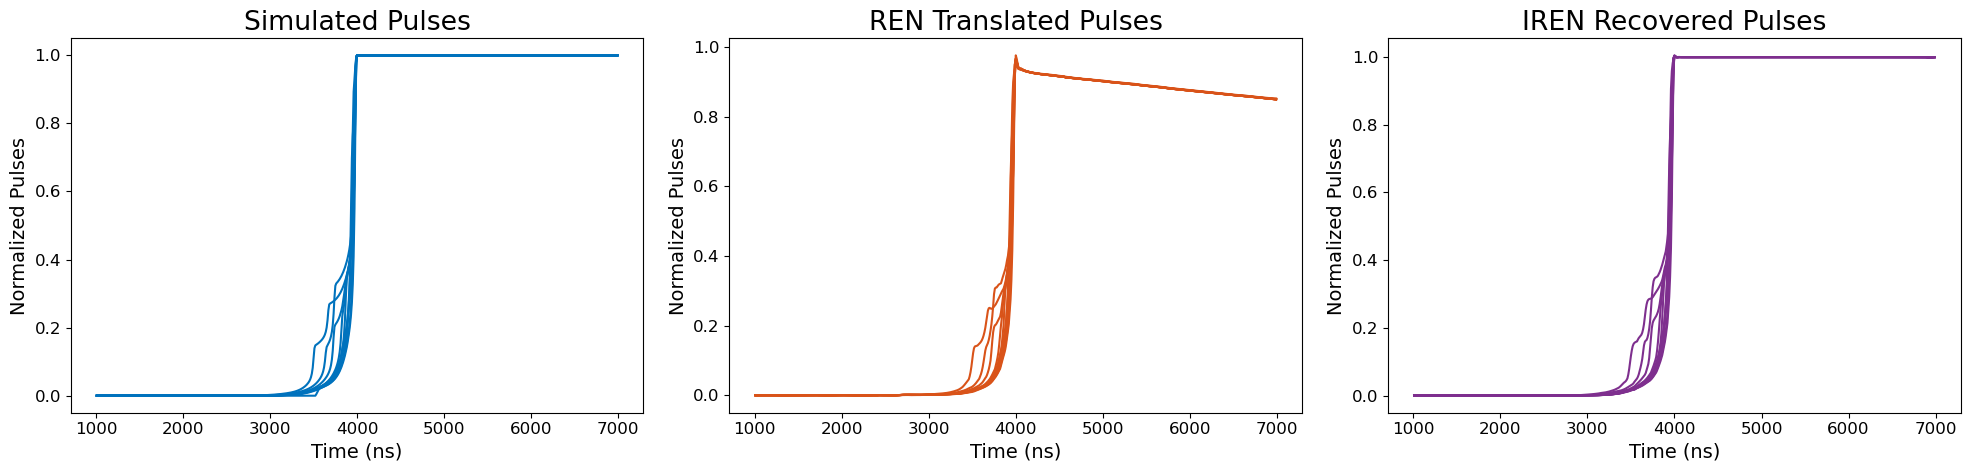

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def plot_cycle_BAB_with_style(netG_A2B, netG_B2A, train_loader, DEVICE, sample_rate=5, eng_peak="eng_peak", save_data=False):
    # Path to save waveform data
    save_path = f"/nas/longleaf/home/kbhimani/CPU-Net/figs/{eng_peak}_waveform_data.npz"
    
    # Initialize lists to store waveforms
    real_Bs, fake_As, recovered_Bs, real_As = [], [], [], []

    time = np.linspace(0, 799, 800)
    cut = (time > 100) & (time < 700)

    if save_data and os.path.exists(save_path):
        print(f"Loading saved waveform data from {save_path}...")
        data = np.load(save_path, allow_pickle=True)
        real_Bs = list(data["real_Bs"])
        fake_As = list(data["fake_As"])
        recovered_Bs = list(data["recovered_Bs"])
        time = data["time"]
    else:
        # Loop over a fixed number of samples
        for _ in range(sample_rate):
            real_A, real_B, a, b = next(iter(train_loader))
            real_A = real_A.to(DEVICE)
            real_B = real_B.to(DEVICE)

            # Generate and recover
            with torch.no_grad():
                fake_A = netG_B2A(real_B)
                recovered_B = netG_A2B(fake_A)

            # Collect waveforms
            real_Bs.append(real_B[0, 0, :].cpu().numpy())
            fake_As.append(fake_A[0, 0, :].cpu().numpy())
            recovered_Bs.append(recovered_B[0, 0, :].cpu().numpy())

        # Save the waveform data
        # if save_data:
        #     np.savez(save_path, real_Bs=real_Bs, fake_As=fake_As, recovered_Bs=recovered_Bs, time=time)
        #     print(f"Saved waveform data to {save_path}")

    # Plot the waveforms
    colors = {
        "real_B": "#0072BD",  # bright blue
        "fake_A": "#D95319",  # bright orange
        "recovered_B": "#7E2F8E",  # purple
    }

    fig, axs = plt.subplots(1, 3, figsize=(20, 5))  
    titles = ["Simulated Pulses", "REN Translated Pulses", "IREN Recovered Pulses"]
    waveform_lists = [real_Bs, fake_As, recovered_Bs]
    color_keys = ["real_B", "fake_A", "recovered_B"]

    for ax, title, waveforms, color_key in zip(axs, titles, waveform_lists, color_keys):
        for i in range(sample_rate):
            ax.plot(time[cut]*sample_rate, waveforms[i][cut], color=colors[color_key], label=title if i == 0 else "")
        ax.set_title(title)
        ax.set_xlabel('Time (ns)', fontsize=14)
        ax.set_ylabel('Normalized Pulses', fontsize=14)
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
    fig.tight_layout()
    pdf_path = f"figs/{eng_peak}_result_comp_1x3_cycle_BAB.pdf"
    plt.savefig(pdf_path)
    print(f"Saved plot to {pdf_path}")
    plt.show()

    
plot_cycle_BAB_with_style(IREN, REN, train_loader, DEVICE, sample_rate=10, eng_peak=eng_peak, save_data=True)


Loading saved waveform data from /nas/longleaf/home/kbhimani/CPU-Net/figs/sep_waveform_data_ABA.npz...
Saved plot to figs/sep_result_comp_1x3_cycle_ABA.pdf


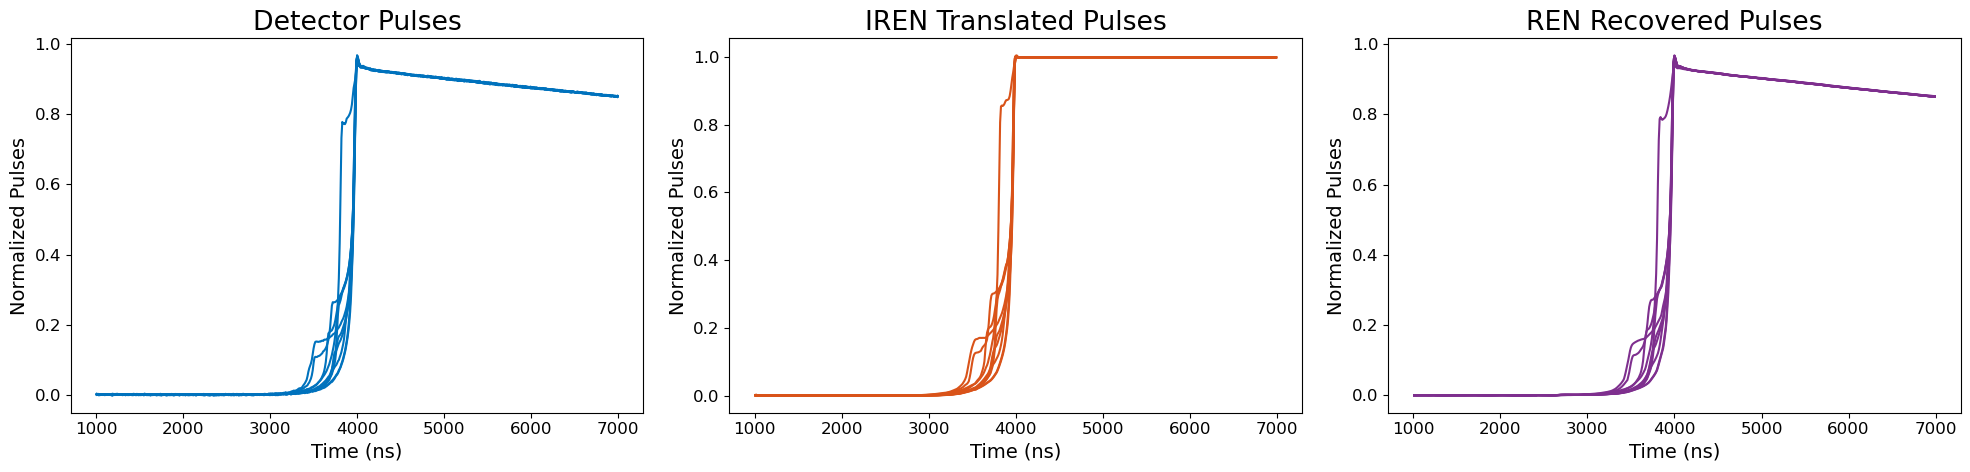

In [32]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import torch

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

def plot_cycle_ABA_with_style(netG_A2B, netG_B2A, train_loader, DEVICE, sample_rate=5, eng_peak="eng_peak", save_data=False):
    # Path to save waveform data
    save_path = f"/nas/longleaf/home/kbhimani/CPU-Net/figs/{eng_peak}_waveform_data_ABA.npz"

    # Initialize lists to store waveforms
    real_As, fake_Bs, recovered_As = [], [], []

    time = np.linspace(0, 799, 800)
    cut = (time > 100) & (time < 700)

    if save_data and os.path.exists(save_path):
        print(f"Loading saved waveform data from {save_path}...")
        data = np.load(save_path, allow_pickle=True)
        real_As = list(data["real_As"])
        fake_Bs = list(data["fake_Bs"])
        recovered_As = list(data["recovered_As"])
        time = data["time"]
    else:
        # Loop over a fixed number of samples
        for _ in range(sample_rate):
            real_A, real_B, a, b = next(iter(train_loader))
            real_A = real_A.to(DEVICE)
            real_B = real_B.to(DEVICE)

            # Generate and recover
            with torch.no_grad():
                fake_B = netG_A2B(real_A)
                recovered_A = netG_B2A(fake_B)

            # Collect waveforms
            real_As.append(real_A[0, 0, :].cpu().numpy())
            fake_Bs.append(fake_B[0, 0, :].cpu().numpy())
            recovered_As.append(recovered_A[0, 0, :].cpu().numpy())

        # Save the waveform data
        # if save_data:
        #     np.savez(save_path, real_As=real_As, fake_Bs=fake_Bs, recovered_As=recovered_As, time=time)
        #     print(f"Saved waveform data to {save_path}")

    # Plot the waveforms
    colors = {
        "real_A": "#0072BD",  # bright blue
        "fake_B": "#D95319",  # bright orange
        "recovered_A": "#7E2F8E",  # purple
    }

    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    titles = ["Detector Pulses", "IREN Translated Pulses", "REN Recovered Pulses"]
    waveform_lists = [real_As, fake_Bs, recovered_As]
    color_keys = ["real_A", "fake_B", "recovered_A"]

    for ax, title, waveforms, color_key in zip(axs, titles, waveform_lists, color_keys):
        for i in range(sample_rate):
            ax.plot(time[cut]*sample_rate, waveforms[i][cut], color=colors[color_key], label=title if i == 0 else "")
        ax.set_title(title)
        ax.set_xlabel('Time (ns)', fontsize=14)
        ax.set_ylabel('Normalized Pulses', fontsize=14)
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
    fig.tight_layout()
    pdf_path = f"figs/{eng_peak}_result_comp_1x3_cycle_ABA.pdf"
    plt.savefig(pdf_path)
    print(f"Saved plot to {pdf_path}")
    plt.show()
plot_cycle_ABA_with_style(IREN, REN, train_loader, DEVICE, sample_rate=10, eng_peak=eng_peak, save_data=True)


In [13]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch

# def visualize_attention_weights_for_both(model_A, model_B, weights_path_A, weights_path_B, test_loader, device):
#     # Load the saved weights for both models
#     model_A.load_state_dict(torch.load(weights_path_A, map_location=device))
#     model_B.load_state_dict(torch.load(weights_path_B, map_location=device))
    
#     # Set both models to evaluation mode
#     model_A.eval()
#     model_B.eval()
    
#     # Get a single batch from the test loader
#     real_A, real_B, a,b = next(iter(test_loader))
    
#     # Assume real_A and real_B are already on the correct device and normalized if necessary
#     real_A = real_A.to(device)
#     real_B = real_B.to(device)

#     # Get the attention weights for the single input instance from both models
#     with torch.no_grad():
#         attention_weights_A = model_A.get_attention_weights(real_A).cpu().numpy()[0]  # Assuming a method that returns attention weights
#         attention_weights_B = model_B.get_attention_weights(real_B).cpu().numpy()[0]  # Assuming a method that returns attention weights

#     time_intervals = [(0, 201, 'tab:blue'), (200, 451, 'tab:red'), (451, 800, 'tab:green')]
#     detector_pulses= real_A[0].cpu().numpy()[0]
#     simulated_pulses=real_B[0].cpu().numpy()[0]
#     # Create figure for visualization
#     fig, axs = plt.subplots(2, 2, figsize=(20, 10))  # Two rows for waveforms and attention, two columns for each model
    
#     # Plot waveform and attention weights for model A (Detector Pulses)
#     for start, end, color in time_intervals:
#         axs[0, 0].plot(np.arange(start, min(end, len(detector_pulses))), detector_pulses[start:end], color=color, label=f'{start}-{end} ns')
#     axs[0, 0].set_title('Detector Pulses')
#     axs[0, 0].legend()

#     axs[1, 0].plot(attention_weights_A, label='Attention Weights A')
#     axs[1, 0].set_title('Attention Weights (Detector Pulses)')
#     axs[1, 0].legend()

#     # Plot waveform and attention weights for model B (Simulated Pulses)
#     for start, end, color in time_intervals:
#         axs[0, 1].plot(np.arange(start, min(end, len(simulated_pulses))), simulated_pulses[start:end], color=color, label=f'{start}-{end} ns') 
#     axs[0, 1].set_title('Simulated Pulses')
#     axs[0, 1].legend()

#     axs[1, 1].plot(attention_weights_B, label='Attention Weights B')
#     axs[1, 1].set_title('Attention Weights (Simulated Pulses)')
#     axs[1, 1].legend()
    
#     # Adjust layout and display the plot
#     plt.tight_layout()
#     # plt.savefig("figs/attention_wf_plot_both.png", dpi=200)
#     plt.show()
    
# netD_A = RNN(get_attention=True)
# netD_B = RNN(get_attention=True)
# weights_path_A = f'model_weights/{eng_peak_load}_netD_A.pth'
# weights_path_B = f'model_weights/{eng_peak_load}_netD_B.pth'

# # Now call the function to visualize the attention weights for both models
# visualize_attention_weights_for_both(netD_A, netD_B, weights_path_A, weights_path_B, train_loader,'cpu')

In [14]:
def calculate_t_cross(wf_blsub, cross):
    """
    Calculate the tp_n from a baseline-subtracted waveform by first finding the maximum time point
    and then searching backwards to find when the waveform first crosses amplitude.
    Parameters:
    - wf_blsub (numpy.array): Baseline-subtracted waveform.
    - cross (float) : Threshold for first crosses amplitude
    Returns:
    - tp_n (float): Calculated time point.
    """
    # Ensure wf is a numpy array
    wf_blsub = np.asarray(wf_blsub)
    tp_max = np.argmax(wf_blsub)
    # Using np.where to find the first index meeting the condition
    zero_crossings = np.where(wf_blsub[:tp_max] < cross)[0]
    if zero_crossings.size > 0:
        return zero_crossings[-1]  # Last crossing before max
    return NaN  # Return NaN if no crossing found
def calc_dt(wf, dt_0, dt_n):
    """
    Calculate the drift time as the difference between t99 and tp_0.
    """
    # t99 = calculate_t_cross(wf, dt_n)
    # tp_0 = calculate_t_cross(wf, cross)
    t99 = calculate_t_cross(wf, dt_n)
    tp_0 = calculate_t_cross(wf, dt_0)
    if np.isnan(t99) or np.isnan(tp_0):
        return np.nan
    return t99 - tp_0

In [15]:
def linear(x, a, b):
        """Linear function ax + b"""
        return a * x + b
def get_tail_slope(wf, plot_sample=False):
    sample = 300
    fit_coefficients = []
    if len(wf) < sample:
        return 0  # Skip waveforms with fewer than 300 samples
    x_data = np.arange(sample)
    y_data = np.log(np.clip(wf[-sample:], 1e-10, None))  # Log of last 300 samples, avoiding log(0)
    try:
        popt, pcov = curve_fit(linear, x_data, y_data, maxfev=100000)
        if plot_sample:
            plot_slope_calc(x_data, y_data, popt, wf[-sample:])
    except Exception as e:
        print(f"Failed to fit waveform due to {e}. Appending NaN values.")
        return 0
    return popt[0]

In [16]:
dt_0 = 0.01
dt_n = 1.00
ts = []
gan_ts = []
sim_ts = []
data_ca = []
gan_ca = []
sim_ca = []
data_wf= []
siggen_wf= []
translated_wf = []
dt_sim = []
dt_data = []
event_eng = []
dt_gan = []
i=0
for wf, wf_deconv,rawwf,c in tqdm(train_loader):
    # if i==20: #processs only 10 batches
    #     break
    bsize = wf.size(0)
    gan_wf = REN(wf_deconv.to(DEVICE).float())
    for iwf in range(bsize):
        datawf = wf[iwf,0].cpu().numpy().flatten()
        siggenwf = wf_deconv[iwf,0].cpu().numpy().flatten()
        transfer_wf = gan_wf[iwf,0].detach().cpu().numpy().flatten()
        ts.append(get_tail_slope(datawf))
        gan_ts.append(get_tail_slope(transfer_wf))
        sim_ts.append(get_tail_slope(siggenwf))
        data_ca.append(calc_current_amplitude(datawf))
        gan_ca.append(calc_current_amplitude(transfer_wf))
        sim_ca.append(calc_current_amplitude(siggenwf))
        siggen_wf.append(siggenwf)
        data_wf.append(datawf)
        translated_wf.append(transfer_wf)
        dt_sim.append(calc_dt(siggenwf, dt_0, dt_n))
        dt_data.append(calc_dt(datawf, dt_0, dt_n))
        dt_gan.append(calc_dt(transfer_wf, dt_0, dt_n))
        # event_eng.append(c["energy"][iwf].cpu().numpy().flatten()[0])
    i += 1

100%|██████████| 396/396 [00:35<00:00, 11.29it/s]


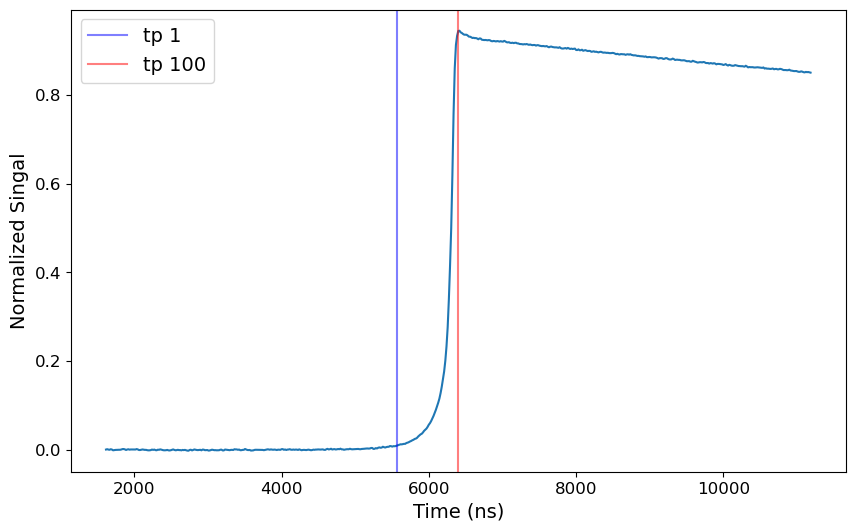

In [17]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
test_wf = data_wf[0]
time = np.linspace(0, 799, 800)
sample_rate = 16
cut = (time > 100) & (time <700)
plt.figure(figsize=(10, 6))
plt.plot(time[cut]*sample_rate,test_wf[cut])
plt.axvline(calculate_t_cross(test_wf, 0.01)*sample_rate, color='b', alpha=0.5, label='tp 1')
plt.axvline(calculate_t_cross(test_wf, 1.00)*sample_rate,color='r', alpha=0.5, label='tp 100')
plt.xlabel("Time (ns)", fontsize=14)
plt.ylabel("Normalized Singal", fontsize=14)
plt.xticks(fontsize=12)  # Bigger tick labels
plt.yticks(fontsize=12)  # Bigger tick labels
plt.legend(fontsize=14)
plt.savefig('figs/time_calc.pdf')

Drift Time IoU between Detector Peak and Simulated Peak: 39.5501921431
Drift Time IoU between Detector Peak and Translated Peak: 62.3862532638


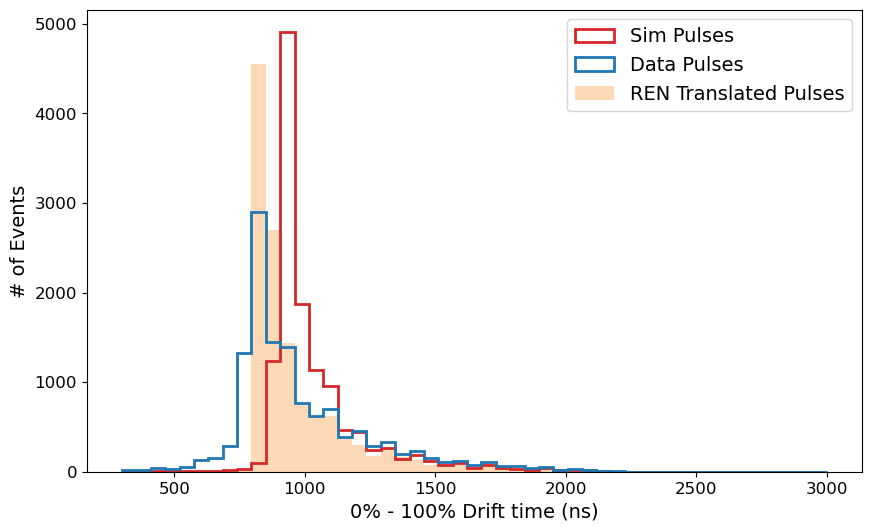

In [18]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
db = np.linspace(300, 3000,50) 
# db = np.linspace(300, 2000, 30) # for DEP
dt_sim_plot= np.array(dt_sim)*sample_rate
dt_data_plot= np.array(dt_data)*sample_rate
dt_gan_plot= np.array(dt_gan)*sample_rate
log_status = False
plt.figure(figsize=(10, 6))

plt.hist(dt_sim_plot, bins=db,histtype="step",linewidth=2,log=log_status,color="tab:red",alpha=1,label="Sim Pulses")
plt.hist(dt_data_plot, bins=db,histtype="step",linewidth=2,log=log_status,color="tab:blue",alpha=1,label="Data Pulses")
plt.hist(dt_gan_plot, bins=db,linewidth=2,log=log_status,color="tab:orange",alpha=0.3,label="REN Translated Pulses")
plt.legend(fontsize=14)
# plt.title(f"{eng_peak.upper()} events on {eng_peak_load.upper()} trained data", fontsize=14)
plt.ylabel("# of Events", fontsize=14)
plt.xlabel("0% - 100% Drift time (ns)", fontsize=14)
plt.xticks(fontsize=12)  # Bigger tick labels
plt.yticks(fontsize=12)  # Bigger tick labels
plt.savefig(f"figs/{eng_peak}_drift_time.pdf")

print(f"Drift Time IoU between Detector Peak and Simulated Peak: {calculate_iou(dt_data_plot, dt_sim_plot, db, normed=False):.10f}")
print(f"Drift Time IoU between Detector Peak and Translated Peak: {calculate_iou(dt_data_plot, dt_gan_plot, db, normed=False):.10f}")

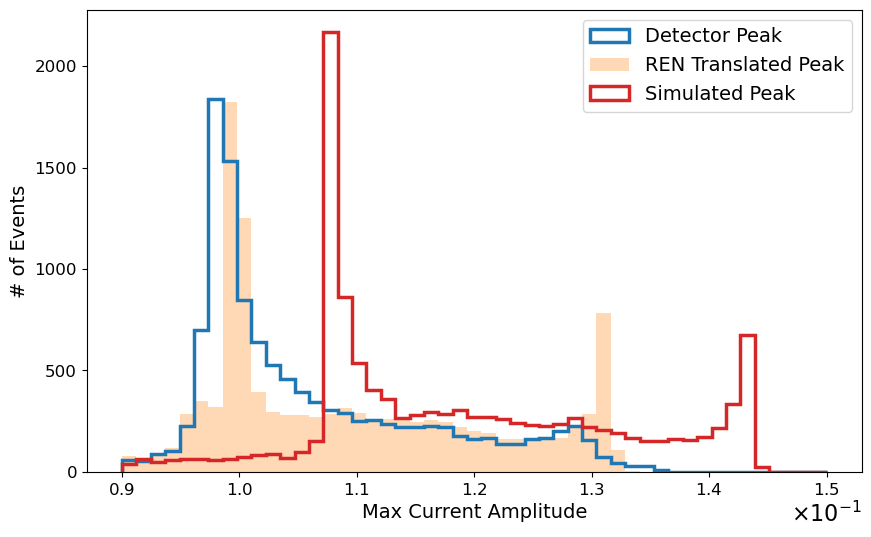

IoU between Detector Peak and Simulated Peak: 27.5296284670
IoU between Detector Peak and Translated Peak: 63.7324920634


In [19]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.ticker as ticker

plt.rcParams['font.size'] = 16
plt.rcParams["figure.figsize"] = (10, 6)

rg = np.linspace(0.09, 0.15, 50)

# data_ca = np.array(data_ca)
# data_ca = np.array(data_ca)
# data_ca = np.array(data_ca)


plt.hist(data_ca, label="Detector Peak", bins=rg, histtype="step", linewidth=2.5, color="#1f77b4")  # Blue
plt.hist(gan_ca, label="REN Translated Peak", bins=rg, alpha=0.3, color="#ff7f0e")  # Orange
plt.hist(sim_ca, label="Simulated Peak", bins=rg, histtype="step", linewidth=2.5, color="tab:red")  

plt.xlabel("Max Current Amplitude", fontsize=14)
plt.ylabel("# of Events", fontsize=14)
# plt.title(f"{eng_peak.upper()} events on {eng_peak_load.upper()} trained data", fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)  # Bigger tick labels
plt.yticks(fontsize=12)  # Bigger tick labels
# Apply scientific notation to x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
# plt.xticks(rotation=45)

plt.savefig(f"figs/{eng_peak.upper()}_amp.pdf")
plt.show()

print(f"IoU between Detector Peak and Simulated Peak: {calculate_iou(data_ca, sim_ca, rg, normed=False):.10f}")
print(f"IoU between Detector Peak and Translated Peak: {calculate_iou(data_ca, gan_ca, rg, normed=False):.10f}")


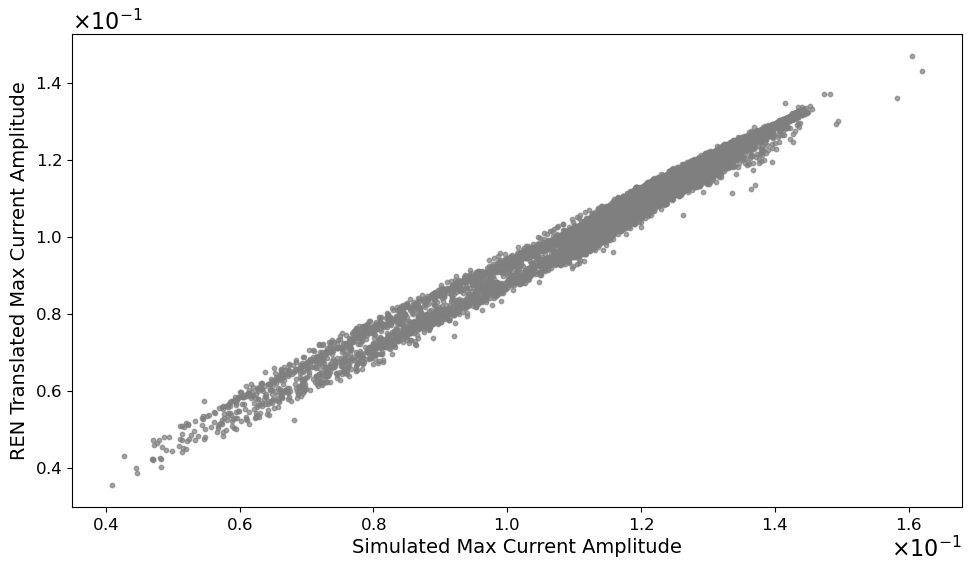

In [20]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(10, 6))
# plt.scatter(sim_ca, data_ca, label='Detector Pulse vs Simulated Pulse', alpha=0.7, color="blue", s=10)
plt.scatter(sim_ca, gan_ca, alpha=0.7, color="tab:gray", s=10)

plt.xlabel('Simulated Max Current Amplitude',fontsize=14)
plt.ylabel('REN Translated Max Current Amplitude',fontsize=14)
# plt.title('Comparison of Current Amplitudes')
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)
# Apply scientific notation to x-axis
plt.xticks(fontsize=12)  # Bigger tick labels
plt.yticks(fontsize=12)  # Bigger tick labels
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.yaxis.get_major_formatter().set_scientific(True)
ax.yaxis.get_major_formatter().set_powerlimits((-1, 1))
plt.tight_layout()
plt.savefig(f"figs/{eng_peak.upper()}_scatter_current_amplitude.png")
plt.show()

In [21]:
ts=np.array(ts)
gan_ts=np.array(gan_ts)
sample_rate = 16

Tail slope IoU between Detector Peak and Translated Peak: 1.0713704171


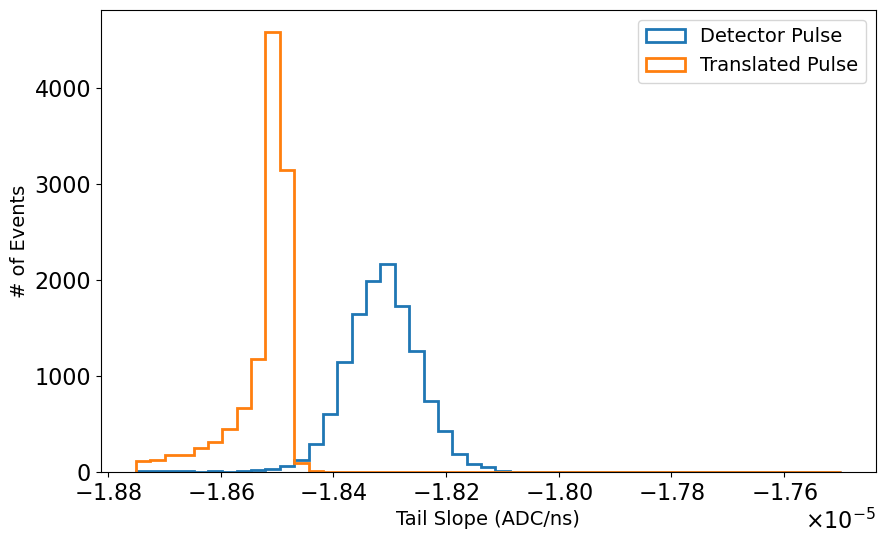

In [22]:
 import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.ticker as ticker
rg = np.linspace(-30e-5/sample_rate,-28e-5/sample_rate,50)
log_status = False
plt.figure(figsize=(10, 6))
plt.hist(ts/sample_rate,bins=rg,histtype="step",linewidth=2,log=log_status, color="#1f77b4",label="Detector Pulse")
plt.hist(gan_ts/sample_rate,bins=rg,histtype="step",linewidth=2,log=log_status, color="#ff7f0e",label="Translated Pulse")
# plt.axvline(x=0,color="#2ca02c",linewidth=3,label="Simulated Pulse")
plt.legend(fontsize=12)
# plt.title(f"{eng_peak.upper()} events on {eng_peak_load.upper()} trained data")
plt.ylabel("# of Events",fontsize=14)
plt.xlabel("Tail Slope (ADC/ns)",fontsize=14)
# Calculate the histograms (with density=True to normalize the histograms)
plt.legend(fontsize=14)


# Apply scientific notation to x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))


print(f"Tail slope IoU between Detector Peak and Translated Peak: {calculate_iou(ts/sample_rate, gan_ts/sample_rate, rg, normed=False):.10f}")

plt.savefig(f"figs/{eng_peak.upper()}_ts.pdf")


/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/nas/longleaf/rhel8/apps/anaconda/2023.03.ood/lib/python3.10/site-packages/numpy/lib/histograms.py:883: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


Tail slope IoU between Detector Peak and Translated Peak: nan


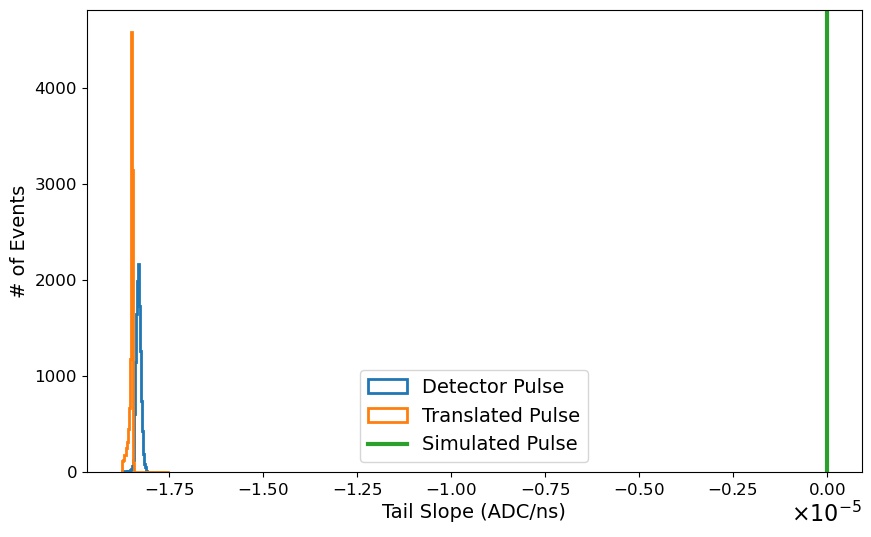

In [23]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.ticker as ticker
rg = np.linspace(-30e-5/sample_rate,-28e-5/sample_rate,50)
log_status = False
plt.figure(figsize=(10, 6))
plt.hist(ts/sample_rate,bins=rg,histtype="step",linewidth=2,log=log_status, color="#1f77b4",label="Detector Pulse")
plt.hist(gan_ts/sample_rate,bins=rg,histtype="step",linewidth=2,log=log_status, color="#ff7f0e",label="Translated Pulse")
plt.axvline(x=0,color="#2ca02c",linewidth=3,label="Simulated Pulse")
plt.legend(fontsize=14)
# plt.title(f"{eng_peak.upper()} events on {eng_peak_load.upper()} trained data",fontsize=12)
plt.ylabel("# of Events",fontsize=14)
plt.xlabel("Tail Slope (ADC/ns)",fontsize=14)
plt.xticks(fontsize=12)  # Bigger tick labels
plt.yticks(fontsize=12)  # Bigger tick labels
# Calculate the histograms (with density=True to normalize the histograms)
plt.legend(fontsize=14)


# Apply scientific notation to x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.xaxis.get_major_formatter().set_scientific(True)
ax.xaxis.get_major_formatter().set_powerlimits((-1, 1))


print(f"Tail slope IoU between Detector Peak and Translated Peak: {calculate_iou(ts, gan_ts, rg, normed=False):.10f}")

plt.savefig(f"figs/{eng_peak.upper()}_ts_with_sim.pdf")


In [24]:
print(len(ts))
print(len(gan_ts))
print('Mean data tau', np.mean(ts/sample_rate))
print('Mean GAN tau', np.mean(gan_ts/sample_rate))
print('Percent diff', abs(100*(np.mean(ts/sample_rate)-np.mean(gan_ts/sample_rate))/(np.mean(ts/sample_rate))))
print('STD data tau', np.std(ts/sample_rate))
print('STD GAN tau', np.std(gan_ts/sample_rate))
print('STD diff', abs(np.std(ts/sample_rate)-np.std(gan_ts/sample_rate)))

12672
12672
Mean data tau -1.831659031620773e-05
Mean GAN tau -1.860493443929526e-05
Percent diff 1.5742237944383364
STD data tau 8.344626455270975e-08
STD GAN tau 2.8988379188446353e-07
STD diff 2.0643752733175378e-07


In [25]:
(1/(np.mean(ts/sample_rate)))/1000

-54.59531401513817

In [26]:
(1/(np.mean(gan_ts/sample_rate)))/1000

-53.74918160893446

In [27]:
sep_alignment, peak_location_ca_sep, peak_location_gan_ca_sep = check_peak_alignment(train_loader, REN, 0, DEVICE)
# Print the location of the peaks for both sep and dep
print(f"SEP Peak location for ca: {peak_location_ca_sep:.6f}, gan_ca: {peak_location_gan_ca_sep:.6f}")

SEP Peak location for ca: 0.000090, gan_ca: 0.000090


In [28]:
# This was used to save waveform for the plot below it
# import torch
# import pickle
# from tqdm import tqdm

# IREN.eval()

# # Placeholder for collected data
# collected_data = []

# for i, (wf, wf_deconv, rawwf, event_ids) in enumerate(tqdm(train_loader)):
#     # Transfer waveforms to DEVICE
#     wf_deconv = wf_deconv.to(DEVICE).float()

#     # Process through IREN
#     with torch.no_grad():
#         transformed_wf = REN(wf_deconv)

#     # Convert tensors to CPU and numpy for storage
#     transformed_wf_np = transformed_wf.cpu().numpy()
#     wf_np = wf.cpu().numpy()
#     wf_deconv_np = wf_deconv.cpu().numpy()

#     # Store the necessary information
#     for j in range(wf_np.shape[0]):
#         collected_data.append({
#             'event_id': event_ids[j].item(),  # Assuming event_ids is a tensor of event IDs
#             # 'original_wf': wf_np[j],
#             'simulated_wf': wf_deconv_np[j],
#             'transformed_wf': transformed_wf_np[j]
#         })

# # Save to a pickle file
# with open('transformed_waveforms_with_events.pickle', 'wb') as handle:
#     pickle.dump(collected_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# print("Data saved successfully.")

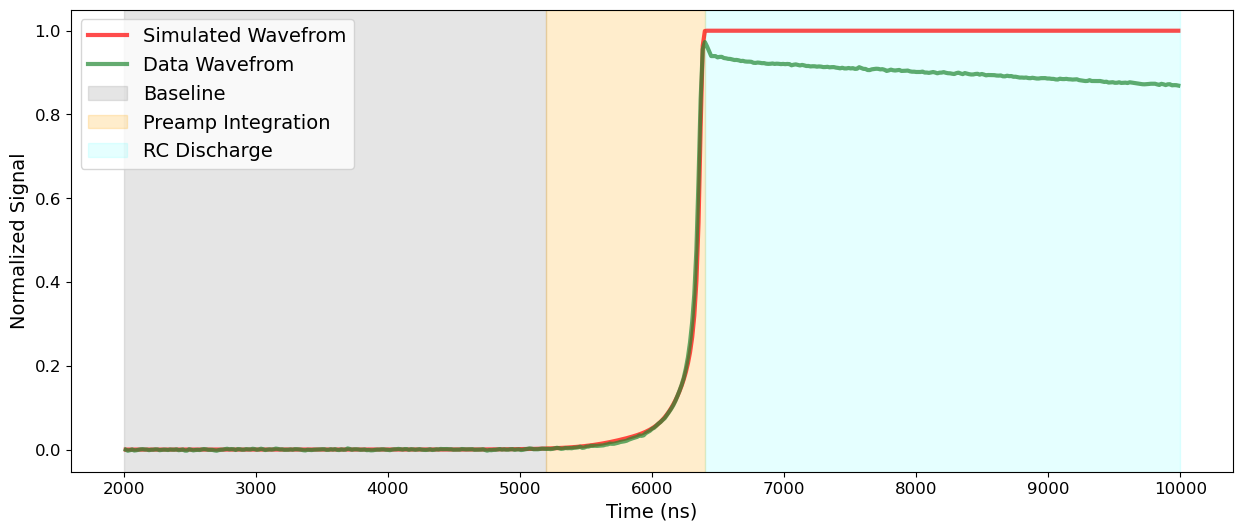

In [29]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import numpy as np
import torch
import matplotlib.pyplot as plt

xlim=200*16
xmax=550*16
# Clear the current session and reload the saved data to verify
loaded_data = np.load("/nas/longleaf/home/kbhimani/CPU-Net/plot_data/waveform_data.npy", allow_pickle=True).item()
# Accessing the data
loaded_detector_pulse = loaded_data["detector_pulse"]
loaded_simulated_pulse = loaded_data["simulated_pulse"]
loaded_translated_pulse = loaded_data["translated_pulse"]
loaded_translated_pulse_inv = loaded_data["translated_pulse_inv"]

num_samples = len(loaded_detector_pulse)

t_l=2000
t_h=10000

# Create a new array for time, assuming samples are spaced 16 ns apart
time_array = np.arange(0, num_samples * 16, 16)  # Time in nanoseconds
time_cut = (time_array > t_l) & (time_array < t_h)



# Plot to verify the loaded data
fig = plt.figure(figsize=(15, 6))
plt.plot(time_array[time_cut], loaded_simulated_pulse[time_cut], label="Simulated Wavefrom", alpha=0.7, color="red", linewidth=3)
plt.plot(time_array[time_cut], loaded_detector_pulse[time_cut], label="Data Wavefrom", alpha=0.7, color="#228833", linewidth=3) #, linestyle=":"
# plt.plot(loaded_translated_pulse, label="REN Output",color="dodgerblue", linewidth = 2)

plt.axvspan(xmin=2000, xmax=325*16, alpha=0.2, color="grey", label="Baseline")
plt.axvspan(xmin=325*16, xmax=400*16, alpha=0.2, color="orange", label="Preamp Integration")
plt.axvspan(xmin=400*16, xmax=t_h, alpha=0.1, color="cyan", label="RC Discharge")
# plt.xlim(xlim,xmax)
plt.xlabel("Time (ns)", fontsize=14)
plt.ylabel("Normalized Signal", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.xticks(fontsize=12)  # Bigger tick labels
plt.yticks(fontsize=12)  # Bigger tick labels
plt.savefig("figs/wf_comp_sim_data.pdf", dpi=300)
plt.show()


In [30]:
#This was used to generate the wavefrom in cycle-gan training example in the thesis

# import matplotlib.pyplot as plt
# import numpy as np
# import os


# # Plot settings
# plot_settings = {
#     "linewidth": 2,
#     "color": "black"  # Academic papers often use black for clarity
# }

# # Dictionary of waveforms and their labels
# waveforms = {
#     "Data_Pulse": detector_pulse,
#     "Simulated_Pulse": simulated_pulse,
#     "REN_Output": translated_pulse,
#     "REN_Inverted": translated_pulse_inv,
# }

# # Generate and save individual plots
# for name, waveform in waveforms.items():
#     plt.figure(figsize=(8, 6))
#     plt.plot(waveform[100:], **plot_settings)
#     plt.xlabel("Time Sample [ns]")
#     plt.ylabel("ADC Counts [a.u.]")
#     plt.tight_layout()
#     plt.savefig(f"figs/{name}.pdf", dpi=300)
#     plt.close()

# print("Waveform plots saved successfully!")


In [31]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Parameters
# num_samples = 150  # Number of samples to analyze from each pulse
# sampling_interval = 16.0  # Time interval of data

# # Function to compute the Power Spectral Density (PSD) from the Fourier Transform
# def compute_psd(signal, sampling_interval):
#     fft = np.fft.rfft(signal)
#     freq = np.fft.rfftfreq(len(signal), d=sampling_interval)
#     psd = np.abs(fft)**2  # Compute the power spectral density
#     return freq, psd

# # Initialize arrays to store results
# fft_data_psd_all = []
# fft_translated_psd_all = []

# # Loop over all pulses
# for data_pulse, translated_pulse in zip(data_wf, translated_wf):
#     # Limit to the first `num_samples` samples
#     data_pulse_limited = data_pulse[:num_samples]
#     translated_pulse_limited = translated_pulse[:num_samples]
    
#     # Compute PSD for data pulses
#     freq_data, psd_data = compute_psd(data_pulse_limited, sampling_interval)
#     # Compute PSD for translated pulses
#     freq_translated, psd_translated = compute_psd(translated_pulse_limited, sampling_interval)
    
#     fft_data_psd_all.append(psd_data)
#     fft_translated_psd_all.append(psd_translated)

# # Convert lists to arrays for averaging
# fft_data_psd_avg = np.mean(fft_data_psd_all, axis=0)
# fft_translated_psd_avg = np.mean(fft_translated_psd_all, axis=0)

# # Use the frequency axis from the first pulse (same for all pulses)
# freq = freq_data

# # Plot the PSDs on a log-log scale
# plt.figure(figsize=(10, 6))
# plt.loglog(freq, fft_data_psd_avg, label="Data Pulses (Average PSD)", color="blue", alpha=0.75)
# plt.loglog(freq, fft_translated_psd_avg, label="Translated Pulses (Average PSD)", color="orange", alpha=0.75)

# # Plot formatting
# plt.xlabel("Frequency [Hz]")
# plt.ylabel("Power Spectral Density (log scale)")
# plt.title("Averaged Power Spectral Density (Log-Log Scale)")
# plt.legend()
# plt.tight_layout()
# plt.show()
